**Dataset**

In total, easy-VQA contains 5k images and ~50k questions, split into training (80%) and testing (20%) sets. The questions have 13 possible answers:

**The Approach**

The standard approach to performing VQA looks something like this:

1. Process the image.
2. Process the question.
3. Combine features from steps 1/2.
4. Assign probabilities to each possible answer.


In [1]:
pip install easy-vqa

     |████████████████████████████████| 3.2MB 2.6MB/s 


 **The Image Model**

First up: our image model. We’ll build a Convolutional Neural Network (CNN) to extract information from the image input. 

This code uses Keras’s Model (functional) API. We’re not using Keras’s Sequential model API because we’ll need to combine our image model and our question model later 

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten,Dense

# The CNN
im_input = Input(shape=(64, 64,3))
x1 = Conv2D(8, 3, padding='same')(im_input)
x1 = MaxPooling2D()(x1)
x1 = Conv2D(16, 3, padding='same')(x1)
x1 = MaxPooling2D()(x1)
x1 = Flatten()(x1)
# Add a final fully-connected layer after the CNN for good measure
x1 = Dense(32, activation='tanh')(x1)

Using TensorFlow backend.


 **The Question Model**

Next up: our question model. Most VQA models would use some kind of Recurrent Neural Network (RNN) to process the question input, but that’s a little overkill for our use case. The questions in the easy-VQA dataset are short, simple, and come from a fixed set of question templates, so they’re much more approachable compared to those you might see in the real world.

In [3]:
from easy_vqa import get_train_questions, get_test_questions
from keras.preprocessing.text import Tokenizer

# Read questions
# train_qs and test_qs are just arrays of question strings
# (we'll use the other variables later)
train_qs, _, _ = get_train_questions()
test_qs, _, _ = get_test_questions()

# Fit tokenizer on the training questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_qs)

# Convert questions to BOW
train_X_seqs = tokenizer.texts_to_matrix(train_qs)
test_X_seqs = tokenizer.texts_to_matrix(test_qs)

# Example BOW:
# [0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
print(train_X_seqs[0])

[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0.]


In [4]:
# We add one because the Keras Tokenizer reserves index 0 and never uses it.
vocab_size = len(tokenizer.word_index) + 1

# The question network
q_input = Input(shape=(vocab_size,))
x2 = Dense(32, activation='tanh')(q_input)
x2 = Dense(32, activation='tanh')(x2)

 **The Merge**

We’ll use a very simple method to merge our image and question vectors: element-wise multiplication. Implementing this is a one-liner with Keras’s Multiply merge layer:

In [5]:
from keras.layers import Multiply

# The CNN
#x1 = # ... code from above

# The question network
#x2 = # ... code from above

out = Multiply()([x1, x2])

**The Output**

Finally, it’s time for our VQA system to produce an answer. Recall that we’re working with a fixed answer set: we know all possible answers and exactly one is guaranteed to be correct.
For this step, we’ll use Softmax to turn our output values into probabilities so we can quantify how sure we are about each possible answer.

In [6]:
# Merge -> output
out = Multiply()([x1, x2]) # from previous section
out = Dense(32, activation='tanh')(out)
out = Dense(13, activation='softmax')(out)

In [7]:
from keras.models import Model
from keras.optimizers import Adam

# The CNN
#im_input = # ... code from above

# The question network
#q_input = # ... code from above

# Merge -> output
#out = # ... code from above

model = Model(inputs=[im_input, q_input], outputs=out)
model.compile(
  Adam(lr=2e-4), # somewhat arbitrarily chosen
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

**The Data Processing**

Now that we’ve got our model figured out, we just need a bit more code to get all our data ready. 

In [8]:
from easy_vqa import get_train_questions, get_test_questions, get_answers

# Read question data
# (we already did this in the BOW section, remember?)
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()

# Read answer data
all_answers = get_answers()

In [9]:
from easy_vqa import get_train_image_paths, get_test_image_paths
from keras.preprocessing.image import load_img, img_to_array

def load_and_proccess_image(image_path):
  # Load image, then scale and shift pixel values to [-0.5, 0.5]
  im = img_to_array(load_img(image_path))
  return im / 255 - 0.5

def read_images(paths):
  # paths is a dict mapping image ID to image path
  # Returns a dict mapping image ID to the processed image
  ims = {}
  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path)
  return ims

train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())

In [10]:
from keras.utils import to_categorical

# Create model input images
train_X_ims = [train_ims[id] for id in train_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

# Create model outputs
train_answer_indices = [all_answers.index(a) for a in train_answers]
test_answer_indices = [all_answers.index(a) for a in test_answers]
train_Y = to_categorical(train_answer_indices)
test_Y = to_categorical(test_answer_indices)

In [11]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

**Training Model**

In [12]:
# Train the model!
h=model.fit(
  # Reminder: train_X_seqs is from this post's BOW section
  [train_X_ims, train_X_seqs],
  train_Y,
  validation_data=([test_X_ims, test_X_seqs], test_Y),
  shuffle=True,
  epochs=25, # somewhat arbitrary, try more epochs if you have time!
  callbacks=[checkpoint],
)

Train on 38575 samples, validate on 9673 samples
Epoch 1/25
38575/38575 [==============================] - 14s 359us/step - loss: 1.0538 - accuracy: 0.6221 - val_loss: 0.7890 - val_accuracy: 0.6699
Epoch 2/25
38575/38575 [==============================] - 8s 197us/step - loss: 0.7717 - accuracy: 0.6734 - val_loss: 0.7379 - val_accuracy: 0.6875
Epoch 3/25
38575/38575 [==============================] - 8s 210us/step - loss: 0.7197 - accuracy: 0.6965 - val_loss: 0.6790 - val_accuracy: 0.7271
Epoch 4/25
38575/38575 [==============================] - 8s 201us/step - loss: 0.6533 - accuracy: 0.7393 - val_loss: 0.6118 - val_accuracy: 0.7625
Epoch 5/25
38575/38575 [==============================] - 8s 197us/step - loss: 0.5946 - accuracy: 0.7573 - val_loss: 0.5723 - val_accuracy: 0.7669
Epoch 6/25
38575/38575 [==============================] - 7s 194us/step - loss: 0.5543 - accuracy: 0.7684 - val_loss: 0.5429 - val_accuracy: 0.7725
Epoch 7/25
38575/38575 [==============================] - 8s 1

**Plotting Results**

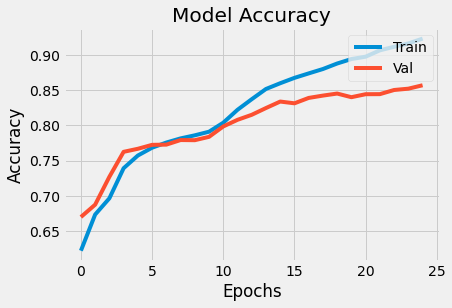

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

#Plotting the trend of model accuracy

plt.plot(h.history["accuracy"])
plt.plot(h.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"],loc="upper right")
plt.show()

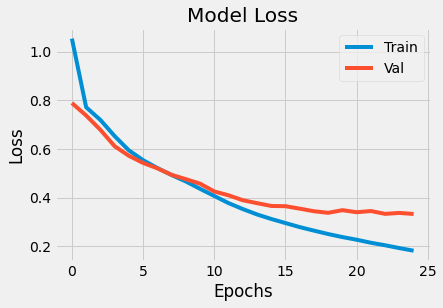

In [16]:
#Plotting the trend of model loss

plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Val"],loc="upper right")
plt.show()